# FLAMBE algorithm

Loading a *Simplex Feature* MDP environment for testing

In [1]:
from pickle import load
import os
import torch
from utils import SimplexEnvironment

MDP = load(open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 10/10 [00:00<00:00, 1999.76it/s]


Defining our Neural network which will be the function approximator of $\phi \in \Phi$ and $\mu \in \Upsilon$ 

In [2]:
from utils import Net
import torch.optim as optim
import torch.nn as nn

criterion = nn.NLLLoss()
optimizer = optim.Adam
optim_params = {"lr":0.001}
model = Net(MDP.S, MDP.A, 5 * MDP.d, criterion, optimizer,  optim_params, real_transitions=t)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
model.to(device)

In [5]:
Jmax = 2000
n = 64

In [6]:
%%time
from tqdm import tqdm
import random
from utils import ListDataset, SimplexPlanner


data_set = []
losses = []

s_prev = 0

with tqdm(range(Jmax)) as tepoch:
    for i in tepoch:

        # Take n Samples
        a = random.randint(0, (model.actions - 1))
        new_data = [(s_prev, a, MDP.next_step_state(s_prev, a))  for _ in range(n)]
        batch_data = random.choices(data_set, k=n) if i > 0 else []
        batch_data.extend(new_data) # Size 2n

        batch_size = len(batch_data) // 2

     

        # Get approximation of MLE
        running_loss = model.backward(ListDataset(batch_data, batch_size= batch_size))

        # Save metrics
        tepoch.set_postfix(loss=f'{running_loss / 10:.3f}')
        losses.append(running_loss)

        # Add all new data to old data
        data_set.extend(new_data) 

        # SimplexPlanner for the next state
        with torch.no_grad():
            planner = model.simplex_planner()
            a_next = planner.get_action(s_prev)
            s_prev = MDP.next_step_state(s_prev, a_next)






100%|██████████| 2000/2000 [03:02<00:00, 10.99it/s, loss=0.434]

CPU times: total: 16min 55s
Wall time: 3min 2s


Graphing stats

Text(0, 0.5, 'NLLLoss')

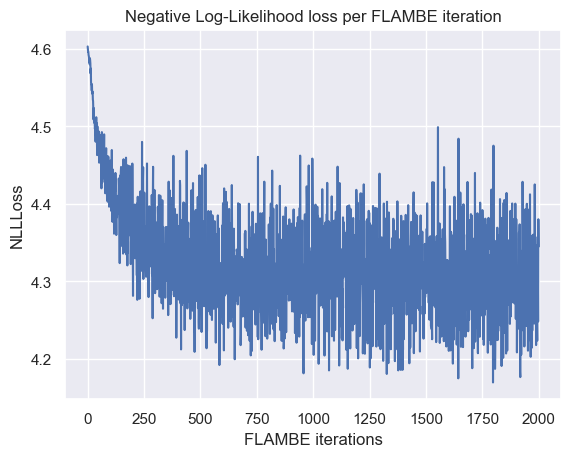

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.plot(losses)
plt.title("Negative Log-Likelihood loss per FLAMBE iteration")
plt.xlabel("FLAMBE iterations")
plt.ylabel("NLLLoss")
# plt.savefig("./images/small_mdp_flambe_losses.pdf",format="pdf", bbox_inches="tight")

Text(0, 0.5, '$\\sum_{a \\in \\mathcal{A}}||X_a - M_a||_{fb}$')

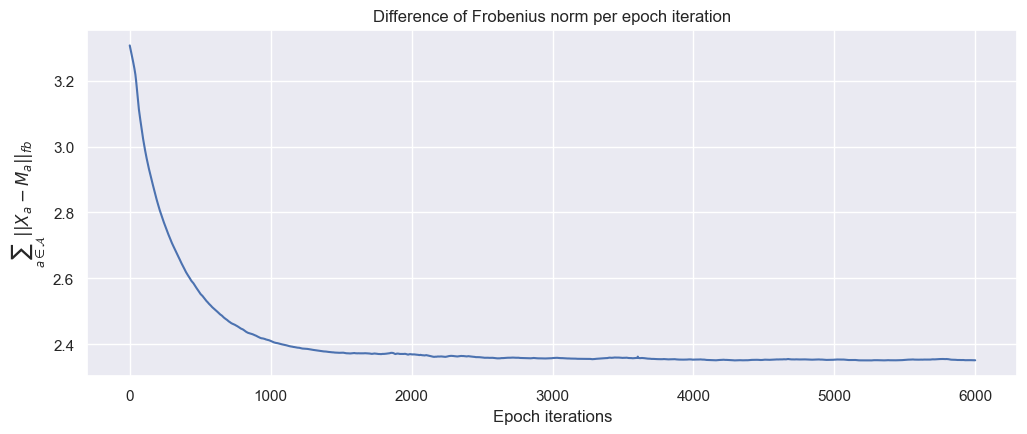

In [9]:
plt.figure(figsize=(12, 4.5))
plt.plot(model.frob_diff)
plt.title("Difference of Frobenius norm per epoch iteration")
plt.xlabel("Epoch iterations")
plt.ylabel("$\sum_{a \in \mathcal{A}}||X_a - M_a||_{fb}$")
# plt.savefig("./images/small_mdp_flambe_fb_diff.pdf",format="pdf", bbox_inches="tight")

Optimal Value Function and Policy

In [11]:
%%time
from utils import PolicyIteration
import numpy as np

def reward(s_prev, a, s_next):
    return np.log(s_prev + 1) + np.log(a + 1) + np.log(s_next + 1)

def next_state_prob(s, a):
            with torch.no_grad():
                return model.forward(torch.from_numpy(s.ravel()).to(model.device).long(), 
                                    torch.from_numpy(a.ravel()).to(model.device).long()).to("cpu").numpy()

pol_iter = PolicyIteration(model.states , model.actions, next_state_prob , reward)

v, pol = pol_iter.run()

  0%|          | 1/2000 [00:00<00:17, 116.31it/s]

CPU times: total: 15.6 ms
Wall time: 18.1 ms


In [12]:
from pickle import load

v_true, pol_true = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_optimals.bin"), 'rb'))

np.mean(np.abs(v - v_true))

0.03388305280524917